In [93]:
# install.packages("tidyverse")
library(tidyverse)
library(lubridate)
library(modelr)

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.0
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.2.1     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: timechange


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




## What is a Markov chain


Source: https://colab.research.google.com/drive/1GwzeHlyBy1j1yTvh8xBkuEZVN7Nu_QgN

In the land of Oz, each day brings exactly one of the following types of weather:

* Nice
* Rain
* Snow

The weather changes every day, with the following probabilities:

* If today is Nice, then tomorrow will be either Rain or Snow with equal probability.
* If today is Rain, then the probability of Rain tomorrow is 1/2, the probability of Nice tomorrow is 1/4, and the probability of snow tomorrow is 1/4.
* If today is Snow, then the probability of Snow tomorrow is 1/2, the probability of Nice tomorrow is 1/4, and the probability of Rain tomorrow is 1/4.


To simulate the weather in Oz, we can define the __Transition Matrix__ $P$. This is a $3 \times 3$ matrix, since there are three types of weather. The columns and rows correspond to _Nice_, _Rain_, and _Snow_, in that order. The entry in row $i$, column $j$ gives the probability that, if the weather today is $j$, then the weather tomorrow will be $i$. Here is the matrix:

$$ P = \left[ \begin{array}{ccc} 0.0 & 0.25 & 0.25 \\ 0.5 & 0.5 & 0.25 \\ 0.5 & 0.25 & 0.5 \end{array}\right]$$

Note that each column sums to 1 (but each row does not).

In [14]:
states <- c("Nice", "Rain", "Snow")
P = matrix(c(0., 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5), nrow=3, dimnames=list(states, states))
P

,Nice,Rain,Snow
Nice,0.00,0.50,0.50
Rain,0.25,0.50,0.25
Snow,0.25,0.25,0.50


__Question:__ _In the long run, what is the probability of each type of weather on a given day?_

First, let's try answering this question by simulation:

In [51]:
s <- "Nice"  # start at s
for (i in 1:1000) {
    # run the Markov chain for 1000 times, updating the state each time
    s <- sample(states, size=1, prob=P[s,])
}
s

[1] "Snow"

In [55]:
s <- "Nice"  # start at s
v <- 1:1000  # empty vector
for (n in 1:1000) {
    for (i in 1:1000) {
        # run the Markov chain for 1000 times, updating the state each time
        s <- sample(states, size=1, prob=P[s,])
    }
    v[n] <- s
}
table(v)

v
Nice Rain Snow 
 188  402  410 

In [57]:
prop.table(table(v))

v
 Nice  Rain  Snow 
0.188 0.402 0.410 

__Question:__ _In the long run, what is the probability of each type of weather on a given day?_

Next, let's use math. Let's think about the question: suppose that the probability that the weather *today* is Nice, Rain, or Snow is $\pi^{(0)}_{\text{Nice}}$, $\pi^{(0)}_{\text{Rain}}$, or $\pi^{(0)}_{\text{Snow}}$. What is the probability that the weather tomorrow is nice/rainy/snowy? Let's call this $\pi^{(1)}_{\text{Nice}}$, etc.


$$
\pi^{(1)}_\text{Nice} = \sum_{\text{today's weather $s$}} \pi^{(0)}_s \times P_{s,\text{Nice}}
$$

In matrix notation, this is written:

$$\pi^{(1)} = \pi^{(0)} P.$$

The quantity on the right-hand side is called matrix-vector multiplication.

Let's try it. Today's weather is half rainy, and half nice:

In [67]:
pi0 = c(Nice=.5, Rain=.5, Snow=0.)

The probability for tomorrow's weather will be:

In [73]:
pi0 %*% P  # Not pi0 * P

Nice,Rain,Snow
0.125,0.5,0.375


__Question:__ _What is the distribution of weather *two days* from now?_

__Answer:__ $\pi^{(2)} = \pi^{(0)} \times P \times P.$

In [72]:
pi0 %*% P %*% P

Nice,Rain,Snow
0.21875,0.40625,0.375


__Question:__ _What is the distribution of weather *$n$ days* from now?_

__Answer:__ $\pi^{(n)} = \pi^{(0)} \times P^n$.

In [76]:
pi_n <- pi0
for (i in 1:100) {
    pi_n <- pi_n %*% P
}
pi_n

Nice,Rain,Snow
0.2,0.4,0.4


### Eigenvectors

The above vector is known as the *steady-state* vector for this Markov chain. An interesting thing is that it does not generally depend on where we started (does not depend on $\pi^{(0)}$). 

In [83]:
pi_n <- rexp(n=3)
pi_n <- pi_n / sum(pi_n)
for (i in 1:100) {
    pi_n <- pi_n %*% P
}
pi_n

Nice,Rain,Snow
0.2,0.4,0.4


The steady-state vector is a property of the Markov chain itself. In other words, it's completely specified by the rate matrix $P$ that we created earlier. Thus, the steady state vector can be "read off" of $P$ by computing something called an _eigendecomposition_.

What happens if we start at the steady-state vector and ask for the probability distribution of tomorrow's weather? As you might expect from the name, nothing changes:

In [84]:
pi_n %*% P  # we get pi_n back

Nice,Rain,Snow
0.2,0.4,0.4


In linear algebra, this tells us that $\pi_n$ is a (left) eigenvector of the matrix $P$, with eigenvalue $1$. 

The traditional definition of an eigenvector $v$ of a matrix $A$, with eigenvalue $\lambda$, satisfies the equation:
$$A v = \lambda v.$$

In [90]:
eigen(t(P))

eigen() decomposition
$values
[1]  1.00 -0.25  0.25

$vectors
          [,1]       [,2]          [,3]
[1,] 0.3333333 -0.8164966 -7.174027e-17
[2,] 0.6666667  0.4082483 -7.071068e-01
[3,] 0.6666667  0.4082483  7.071068e-01


Here, since we are multiplying the matrix $P$ on the left (instead of the right, as is usually the case), we have to perform an eigendecomposition of the *transpose* of $P$. Note also that the eigenvector in the first column is only determined up to scaling. Once we rescale it to sum to one, we will get that it equals $\pi^{(n)}$ as computed above by the power method.

## Ranking teams
We will use a model called [logistic regression MCMC](https://pdfs.semanticscholar.org/bb21/8ea8e16cc43afb7f50eefc0bea4b0fd35ff1.pdf) to build rankings for the NCAA teams. The basic model is as follows:
- We imagine that there is an imaginary person whose job it is to vote on the best team. 
- The voter picks a random team as the best to begin with, and then iterates the following procedure: 
    - Given that the voter currently believes that team $A$ is the best, she picks a random game that team $A$ played versus some team $B$. 
    - With probability $p$, the voter decides that the winner of $A$ vs. $B$ is the new best team, and with probability $(1-p)$ the voter decides that the *loser* is the new best team.

Suppose team $i$ played $N_i$ games in total. Let $w_{ij}$ and $\ell_{ij}$ be the number of games that $i$ won/lost against team $j$. The probability that our voter goes from thinking that $i$ is the best team, to thinking that $j$ is the best team, is 

$$M_{ij} =\frac{1}{N_i}[w_{ij}(1-p) + \ell_{ij}p].$$

Also, the total number of games won (lost) by team $i$ is $W_i$ ($L_i$).


In words:

> Toss of a fair $N_i$-sided die to select a game, followed by the toss of a weighted coin to determine whether the next state will correspond to the selected game’s winner (with probability $p$) or loser (with probability 1 – $p$).

The probability $p$ should not necessarily be fixed. It should be high if team $A$ was "clearly better" than team $B$, whereas if $A$ just "barely beat" team $B$ then it should be close to 1/2. 

But for now, we'll set $p=1/2$. If there is time later, we'll see about estimating $p$ from data for each pair of teams.

Finally we construct our voter model. We'll make a matrix whose entry $M_{ij}$ equals the probability, estimated by our logistic regression model, that team $i$ is better than team $j$. Each time we cast a vote with probability $M_{ij}$ that team $i$ is better than team $j$. Our estimate of the best team is the one for whom we most frequently vote.

Let's illustrate this procedure with three teams: <span style="color: navy;">Michigan</span>, <span style="color: darkgreen">Michigan State</span>, and <span style="color: red;">Ohio State</span>. Our matrix M looks like:

$$
M = 
\begin{pmatrix}
\color{navy}{.6} & \color{darkgreen}{.3} & \color{red}{.1}  \\ 
\color{navy}{.2} & \color{darkgreen}{.4} & \color{red}{.4}  \\ 
\color{navy}{.7} & \color{darkgreen}{.1} & \color{red}{.2} 
\end{pmatrix}
$$

Row/column 1 corresponds to Michigan, row/column 2 to MSU, row/column 3 corresponds to Ohio State. If I'm in row 1, then there is a 30% chance that I vote for Michigan State to be the best, and a 10% chance that I vote for Ohio State to be the best; otherwise, I vote for Michigan to be the best.

In [28]:
mioh <- c("UM", "MSU", "OSU")
M = matrix(c(.6, .2, .7, .3, .4, .1, .1, .4, .2), nrow=3, dimnames=list(mioh, mioh)) %>% print

     UM MSU OSU
UM  0.6 0.3 0.1
MSU 0.2 0.4 0.4
OSU 0.7 0.1 0.2


We can simulate one round of voting by multiplying this matrix with itself:

In [29]:
M %*% M
# ^^^ matrix multiplication

,UM,MSU,OSU
UM,0.49,0.31,0.20
MSU,0.48,0.26,0.26
OSU,0.58,0.27,0.15


If we repeat this a large number of times, something interesting happens:

In [30]:
P <- M
for (i in 1:10) P <- P %*% P
P

,UM,MSU,OSU
UM,0.5057471,0.2873563,0.2068966
MSU,0.5057471,0.2873563,0.2068966
OSU,0.5057471,0.2873563,0.2068966


The probabilities have converged. 

Now let's use what we learned above to compute the steady-state vector using an eigendecomposition:

In [184]:
evd <- eigen(t(M))
p <- evd$vectors[,1]
p <- abs(p / sum(p))
names(p) <- rownames(M)
p

       UM       MSU       OSU 
0.5057471 0.2873563 0.2068966 

The cool thing about this approach is that it works even when every team did not play every other team.

$$
M = 
\begin{pmatrix}
\color{navy}{.6} & \color{darkgreen}{.4} & \color{red}{0}  \\ 
\color{navy}{.2} & \color{darkgreen}{.4} & \color{red}{.4}  \\ 
\color{navy}{0} & \color{darkgreen}{.5} & \color{red}{.5} 
\end{pmatrix}
$$


In [36]:
M = matrix(c(.6, .2, 0, .4, .4, .5, 0, .4, .5), nrow=3, dimnames=list(mioh, mioh)) %>% print
evd <- eigen(t(M))
p <- evd$vectors[,1]
(p <- abs(p / sum(p)) %>% setNames(rownames(M)))

     UM MSU OSU
UM  0.6 0.4 0.0
MSU 0.2 0.4 0.4
OSU 0.0 0.5 0.5


UM       MSU       OSU 
0.2173913 0.4347826 0.3478261

## NCAA data
Finally, we're going to study data from the latest season of NCAA basketball:

In [91]:
load(url('https://datasets.stats306.org/ncaa_2023.RData'))

In [97]:
# 1. keep only the rows and columns we're interested in
gp1 <- ncaa_2023 %>% filter(location != "Neutral") %>% 
    select(location, school_name, opponent_name, score, opponent_score, game_date) %>%
    print

# A tibble: 28,631 × 6
   location school_name        opponent_name   score opponent_score game_date 
   <chr>    <chr>              <chr>           <dbl>          <dbl> <date>    
 1 Away     A&M-Corpus Christi Mississippi St.    44             63 2022-11-07
 2 Home     A&M-Corpus Christi UTSA               75             55 2022-11-11
 3 Home     A&M-Corpus Christi Trinity (TX)       91             73 2022-11-14
 4 Home     A&M-Corpus Christi UTRGV              97             75 2022-11-17
 5 Away     A&M-Corpus Christi UTEP               67             72 2022-11-25
 6 Away     A&M-Corpus Christi UTRGV              82             89 2022-11-30
 7 Home     A&M-Corpus Christi Texas Lutheran    100             63 2022-12-07
 8 Away     A&M-Corpus Christi Arizona            61             99 2022-12-13
 9 Home     A&M-Corpus Christi Schreiner         104             69 2022-12-16
10 Away     A&M-Corpus Christi Oklahoma St.       58             81 2022-12-20
# … with 28,621 more rows


In [98]:
# 2. place home and away team into an easier format
gp2 <- gp1 %>% mutate(
        home_team = ifelse(location == "Home", school_name, opponent_name),
        away_team = ifelse(location == "Away", school_name, opponent_name),
        home_score = ifelse(location == "Home", score, opponent_score),
        away_score = ifelse(location == "Away", score, opponent_score)
    ) %>% select(starts_with(c("home", "away")), game_date) %>% print

# A tibble: 28,631 × 5
   home_team          home_score away_team          away_score game_date 
   <chr>                   <dbl> <chr>                   <dbl> <date>    
 1 Mississippi St.            63 A&M-Corpus Christi         44 2022-11-07
 2 A&M-Corpus Christi         75 UTSA                       55 2022-11-11
 3 A&M-Corpus Christi         91 Trinity (TX)               73 2022-11-14
 4 A&M-Corpus Christi         97 UTRGV                      75 2022-11-17
 5 UTEP                       72 A&M-Corpus Christi         67 2022-11-25
 6 UTRGV                      89 A&M-Corpus Christi         82 2022-11-30
 7 A&M-Corpus Christi        100 Texas Lutheran             63 2022-12-07
 8 Arizona                    99 A&M-Corpus Christi         61 2022-12-13
 9 A&M-Corpus Christi        104 Schreiner                  69 2022-12-16
10 Oklahoma St.               81 A&M-Corpus Christi         58 2022-12-20
# … with 28,621 more rows


In [99]:
# 3. get the two games that each team played side-by-side
gp3 <- inner_join(gp2, gp2, 
                  join_by(home_team == away_team, away_team == home_team), 
                  suffix=c("_1", "_2")) %>%
        filter(game_date_1 != game_date_2) %>% distinct %>% print

Warning message in inner_join(gp2, gp2, join_by(home_team == away_team, away_team == :
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 4 of `x` matches multiple rows in `y`.
ℹ Row 20 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”


# A tibble: 8,958 × 8
   home_team       home_…¹ away_…² away_…³ game_dat…⁴ home_…⁵ away_…⁶ game_dat…⁷
   <chr>             <dbl> <chr>     <dbl> <date>       <dbl>   <dbl> <date>    
 1 A&M-Corpus Chr…      97 UTRGV        75 2022-11-17      89      82 2022-11-30
 2 UTRGV                89 A&M-Co…      82 2022-11-30      97      75 2022-11-17
 3 Northwestern S…      59 A&M-Co…      65 2022-12-31      83      75 2023-02-25
 4 A&M-Corpus Chr…      91 UIW          61 2023-01-04      71      80 2023-01-07
 5 UIW                  71 A&M-Co…      80 2023-01-07      91      61 2023-01-04
 6 A&M-Corpus Chr…      82 Southe…      85 2023-01-12      72      83 2023-02-04
 7 A&M-Corpus Chr…      97 New Or…      79 2023-01-14      69      86 2023-02-02
 8 Lamar Universi…      68 A&M-Co…      66 2023-01-19      61      52 2023-02-11
 9 Houston Christ…      90 A&M-Co…      78 2023-01-21      91      68 2023-02-09
10 A&M-Corpus Chr…      96 Nichol…      86 2023-01-26      74      78 2023-02-16
# … wi

In [106]:
# 4. create columns for regression
game_pairs <- gp3 %>% 
    mutate(home_margin = home_score_1 - away_score_1, 
           beat_on_road = away_score_2 > home_score_2)

In [197]:
# create matrix of all team pairs
all_teams <- game_pairs$home_team %>% sort %>% unique
M <- matrix(0, nrow=length(all_teams), ncol=length(all_teams))
rownames(M) <- all_teams
colnames(M) <- all_teams
p <- 0.8
gp.pred <- mutate(game_pairs, p = p)
for (team in all_teams) {
    df <- filter(gp.pred, home_team == team) %>% 
        mutate(win = (home_score_1 > away_score_1) + (home_score_2 < away_score_2),
               loss = 2 - win)
    v <- df$win * (1 - p) + df$loss * p
    M[team, df$away_team] = v / sum(df$win + df$loss)
}
diag(M) <- 1 - rowSums(M)

In [203]:
U <- M
for (i in 1:20) {
    U <- U %*% U
}

In [207]:
sort(-U[,1])

Indiana St.         Southern Ill.                   UNI 
         -0.004377655          -0.004377655          -0.004377655 
              Belmont                 Drake          Missouri St. 
         -0.004377655          -0.004377655          -0.004377655 
           Murray St.                   UIC               Bradley 
         -0.004377655          -0.004377655          -0.004377655 
           Evansville            Valparaiso          Illinois St. 
         -0.004377655          -0.004377655          -0.004377655 
            Louisiana                   ULM          Arkansas St. 
         -0.004377655          -0.004377655          -0.004377655 
        South Alabama             Texas St.                  Troy 
         -0.004377655          -0.004377655          -0.004377655 
       Southern Miss.          Old Dominion             App State 
         -0.004377655          -0.004377655          -0.004377655 
          Georgia St.         James Madison              Marshall 
         -0.004377655          -0.004377655          -0.004377655 
         Ga. Southern      Coastal Carolina      Northwestern St. 
         -0.004377655          -0.004377655          -0.004377655 
     Lamar University   Southern California     Tex. A&M-Commerce 
         -0.004377655          -0.004377655          -0.004377655 
              Arizona           Arizona St.              Colorado 
         -0.004377655          -0.004377655          -0.004377655 
               Oregon            Oregon St.      Southeastern La. 
         -0.004377655          -0.004377655          -0.004377655 
             Stanford                  UCLA        Washington St. 
         -0.004377655          -0.004377655          -0.004377655 
             Nicholls                   UIW            Washington 
         -0.004377655          -0.004377655          -0.004377655 
           California               McNeese                  Utah 
         -0.004377655          -0.004377655          -0.004377655 
          New Orleans     Houston Christian    A&M-Corpus Christi 
         -0.004377655          -0.004377655          -0.004377655 
        Eastern Wash.             Weber St.             Idaho St. 
         -0.004377655          -0.004377655          -0.004377655 
              Montana           Montana St.        Northern Colo. 
         -0.004377655          -0.004377655          -0.004377655 
         Portland St.        Sacramento St.                 Idaho 
         -0.004377655          -0.004377655          -0.004377655 
       Northern Ariz.          South Dakota                Denver 
         -0.004377655          -0.004377655          -0.004377655 
     North Dakota St.                 Omaha       St. Thomas (MN) 
         -0.004377655          -0.004377655          -0.004377655 
         North Dakota           Kansas City      South Dakota St. 
         -0.004377655          -0.004377655          -0.004377655 
                UTRGV          Western Ill.          Oral Roberts 
         -0.004377655          -0.004377655          -0.004377655 
   California Baptist          Grand Canyon           Sam Houston 
         -0.004377655          -0.004377655          -0.004377655 
         Tarleton St.             Utah Tech           Utah Valley 
         -0.004377655          -0.004377655          -0.004377655 
    Abilene Christian          UT Arlington         Southern Utah 
         -0.004377655          -0.004377655          -0.004377655 
            Seattle U                   SFA        New Mexico St. 
         -0.004377655          -0.004377655          -0.004377655 
                 UTEP                   FIU           North Texas 
         -0.004377655          -0.004377655          -0.004377655 
        Fla. Atlantic                  Rice                   UAB 
         -0.004377655          -0.004377655          -0.004377655 
         Middle Tenn.           Western Ky.        Louisiana Tech 
         -0.004377655          -0.004377655          -0.0

## Logistic regression model
To predict the results of March Madness, we need a way to estimate 

$$\mathbb{P}(\text{Team A will beat team B on a neutral court}).$$

There are many different possible strategies. In this lecture, we will focus on a model that depends on only one thing: the *margin of victory* when they played in the regular season. We will estimate

$$\mathbb{P}(\text{Team A will beat team B on a neutral court}\mid \text{Team A's home margin vs. Team B was $x$ points}).$$


That is, we want to estimate a function $p(x)$ that returns this probability. 

Recall logistic regression from last week:

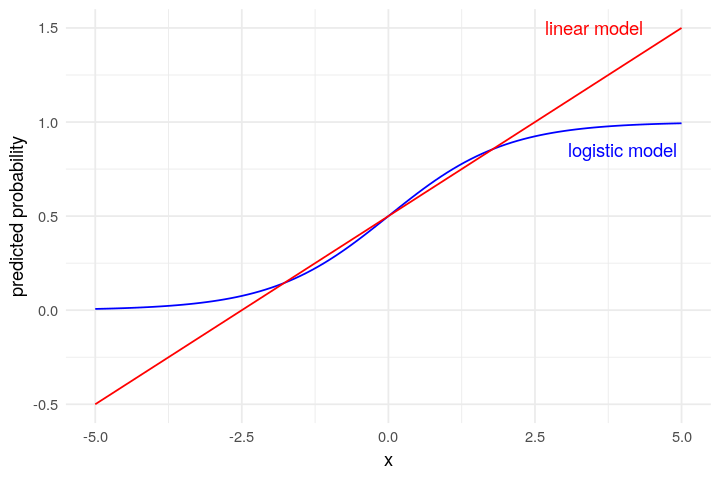

## 🤔 Quiz

Suppose Michigan has a $p=.8$ chance of winning the NCAA title. What are Michigan's *log-odds* of winning?

(Hint: their odds of winning are $p/(1-p) = 4:1$.

<ol style="list-style-type: upper-alpha;">
    <li>-1.38</li>
    <li>-.25</li>
    <li>0.0</li>
    <li>.25</li>
    <li>1.38</li>
</ol>

In [ ]:
# log odds

## 🤔 Quiz

Suppose the log-odds of Michigan winning the NCAA title are 1.0. What is Michigan's *probability* of winning?

Hint:

$$
\begin{align}
x &= \log\left(\frac{p}{1-p}\right) \\
p &= \frac{1}{1+\exp(-x)}
\end{align}
$$

<ol style="list-style-type: upper-alpha;">
    <li>-.51</li>
    <li>0.0</li>
    <li>.12</li>
    <li>.73</li>
    <li>.99</li>
</ol>

In [40]:
# probability of winning

## 🤔 Quiz

```
Call:  glm(formula = y ~ x, family = "binomial")

Coefficients:
(Intercept)            x  
    -0.7879       0.8797  

Degrees of Freedom: 2200 Total (i.e. Null);  2199 Residual
Null Deviance:	    2769 
Residual Deviance: 2750 	AIC: 2754
```

When $x=1.3$, what is the predicted probability that $y=1$?

<ol style="list-style-type: upper-alpha;">
    <li>50-60%</li>
    <li>60-70%</li>
    <li>70-80%</li>
    <li>80-90%</li>
    <li>&gt; 90%</li>
</ol>

In [42]:
# predicted probability

$$\mathbb{P}(\text{Team A will beat team B on a neutral court}\mid \text{Team A's home margin vs. Team B was $x$ points}).$$

Can we use logistic regression to estimate this model? No, because we do not observe the left hand side! So first, we have to think of a way around that.

### Home-court advantage

- If a team is playing at home, let's assume that they get an automatic boost of $+h$ points, known as the _home-court advantage_.
- A team that wins by $x$ points at home would be expected to win by $x – h$ at the neutral site.
- How do we estimate the home court advantage? Thinking back to our model, consider the value of $h$ such that 

$$\mathbb{P}(\text{Team A will beat team B on an away court}\mid \text{Team A's home margin vs. Team B was $h$ points}) = \frac{1}{2}.$$

- This says that A's inherent advantage over B is exactly cancelled out by B's home court advantage. 
- Thus, A's advantage in front of their home crowd is $2h$, and their advantage in front of a neutral crowd is $h$. 

So 
$$\mathbb{P}(\text{Team A will beat team B on a neutral court}\mid \text{Team A's home margin vs. Team B was $x$ points}) \approx \mathbb{P}(\text{Team A will beat team B on B's court}\mid \text{Team A's home margin vs. Team B was $x + h$ points}).$$




To use logistic regression to estimate this function, we'll create a dataset of pairs of games. Most conference teams play each other twice per season, once at each campus. We'll look at the outcome of one of the games and use it to predict the outcome of the second game according to the above model.

### Data format
To estimate this regression model, we need a data frame that looks like:
```
# A tibble: 8,958 × 2
   beat_on_road home_margin
   <lgl>              <dbl>
 1 FALSE                 22
 2 FALSE                  7
 3 FALSE                 -6
 4 TRUE                  30
 5 FALSE                 -9
 6 TRUE                  -3
 7 TRUE                  18
 8 FALSE                  2
 9 FALSE                 12
10 TRUE                  10
# … with 8,948 more rows
```

I had to think for a few minutes about how to create this data frame. We'll to it in stages:

In [12]:
# 1. keep only the rows and columns we're interested in
gp1 <- ncaa_2023 %>% filter(location != "Neutral") %>% 
    select(location, school_name, opponent_name, score, opponent_score, game_date) %>%
    print

# A tibble: 28,631 × 6
   location school_name        opponent_name   score opponent_score game_date 
   <chr>    <chr>              <chr>           <dbl>          <dbl> <date>    
 1 Away     A&M-Corpus Christi Mississippi St.    44             63 2022-11-07
 2 Home     A&M-Corpus Christi UTSA               75             55 2022-11-11
 3 Home     A&M-Corpus Christi Trinity (TX)       91             73 2022-11-14
 4 Home     A&M-Corpus Christi UTRGV              97             75 2022-11-17
 5 Away     A&M-Corpus Christi UTEP               67             72 2022-11-25
 6 Away     A&M-Corpus Christi UTRGV              82             89 2022-11-30
 7 Home     A&M-Corpus Christi Texas Lutheran    100             63 2022-12-07
 8 Away     A&M-Corpus Christi Arizona            61             99 2022-12-13
 9 Home     A&M-Corpus Christi Schreiner         104             69 2022-12-16
10 Away     A&M-Corpus Christi Oklahoma St.       58             81 2022-12-20
# … with 28,621 more rows


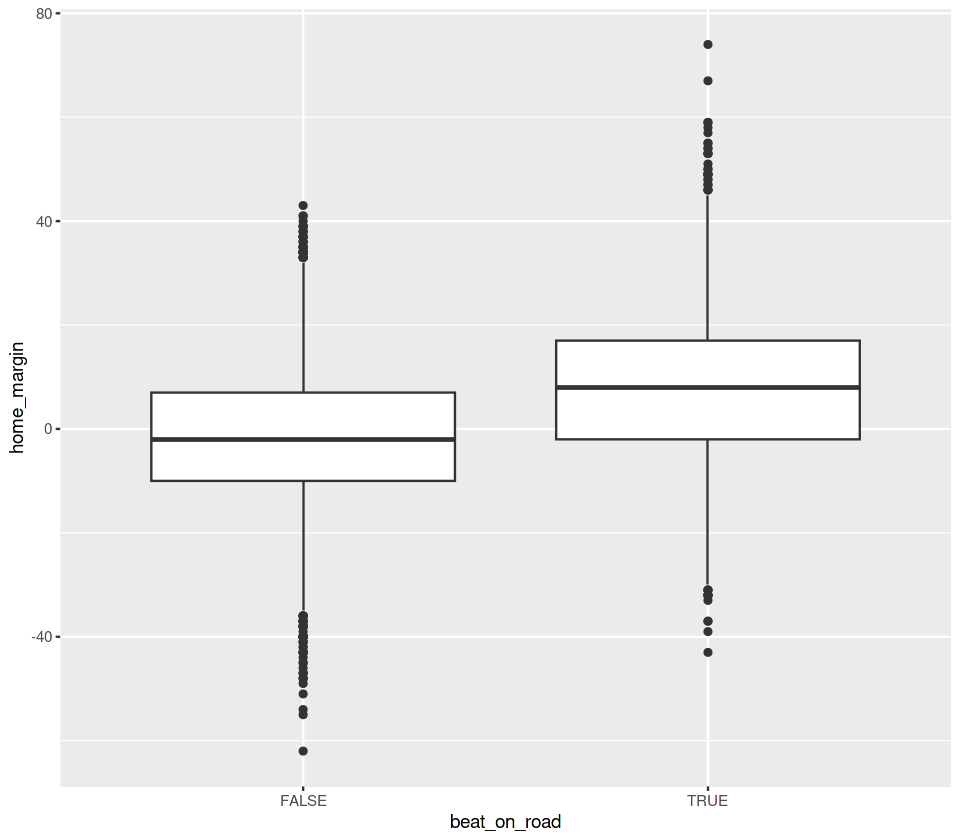

In [24]:
ggplot(game_pairs, aes(x = beat_on_road, y = home_margin)) + geom_boxplot()

In [26]:
model = glm(beat_on_road ~ home_margin, data = game_pairs, family = "binomial")
summary(model)


Call:
glm(formula = beat_on_road ~ home_margin, family = "binomial", 
    data = game_pairs)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9818  -1.0118  -0.6783   1.1471   2.3611  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.455685   0.023621  -19.29   <2e-16 ***
home_margin  0.052750   0.001771   29.78   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 12240  on 8957  degrees of freedom
Residual deviance: 11174  on 8956  degrees of freedom
AIC: 11178

Number of Fisher Scoring iterations: 4


Let's see how well our logistic regression model fits to data:

In [60]:
predictions <- game_pairs %>% group_by(home_margin) %>% 
    summarize(p_win = mean(beat_on_road), sdp = sd(beat_on_road)) %>%
    add_predictions(model) %>% mutate(pred = plogis(pred))

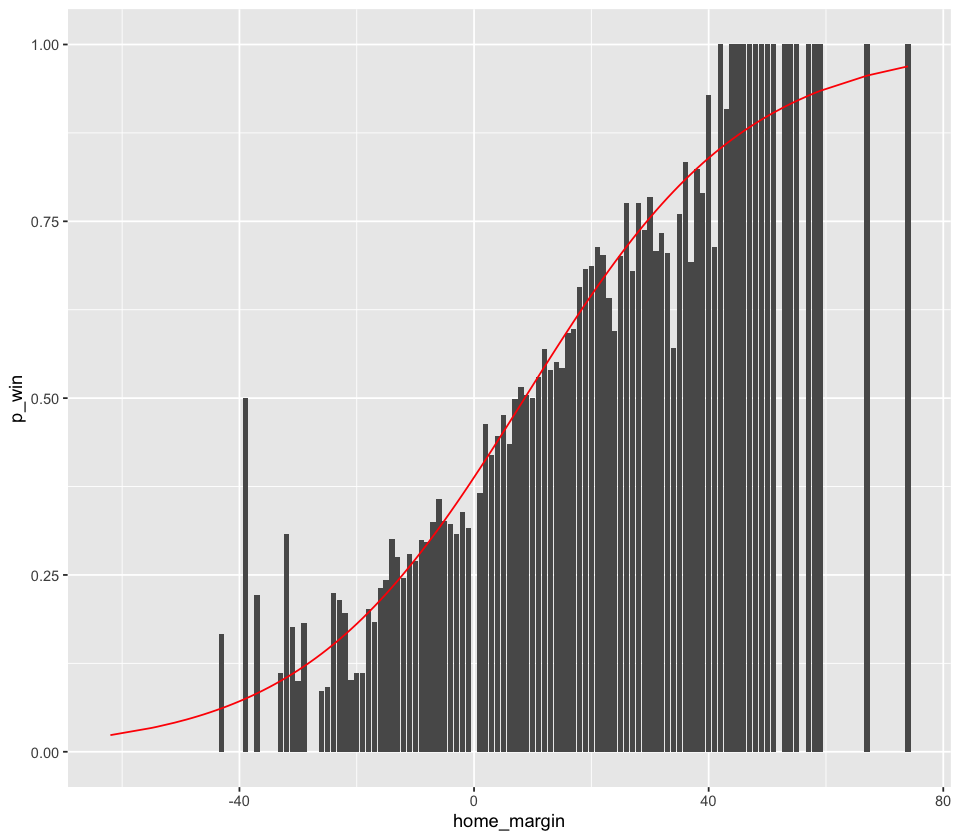

In [61]:
predictions %>% 
    ggplot(aes(x = home_margin)) + 
    geom_col(aes(y = p_win)) + 
    geom_line(aes(y = pred), color = "red")

Our logistic regression model is 

$$\log \left( \frac{p}{1-p} \right) = \alpha + \beta x.$$ 

If $p=1/2$ then the LHS is zero, and we get simply $h = -\alpha/\beta$.

In [74]:
beta = coef(model)
h = -beta[1] / beta[2]
h
r_H = function(x) plogis(beta[1] + beta[2] * (x + h))
r_H(0)

(Intercept) 
   8.638662

(Intercept) 
        0.5

Now let's write code that forms this matrix for all the teams in our data set. To make things go faster, we're only going to look at the teams that formed the midwest portion of this year's tournament bracked

In [67]:
filter(gp.pred, home_team == "Texas A&M") %>% 
    mutate(win = (home_score_1 > away_score_1) + (home_score_2 < away_score_2),
           loss = 2 - win) %>% select(home_team, away_team, win, loss, p=pred)

home_team,away_team,win,loss,p
<chr>,<chr>,<int>,<dbl>,<dbl>
Texas A&M,Arkansas,1,1,0.4652590
Texas A&M,Auburn,2,0,0.4521623
Texas A&M,Florida,2,0,0.4133372
Texas A&M,LSU,2,0,0.5572623
Texas A&M,Missouri,2,0,0.6210027


In [ ]:
all_teams <- game_pairs$home_team %>% sort %>% unique
M <- matrix(0, nrow=length(all_teams), ncol=length(all_teams))
rownames(M) <- all_teams
colnames(M) <- all_teams
gp.pred <- mutate(game_pairs, p=r_H(home_margin))
for (team in all_teams) {
    df <- filter(gp.pred, home_team == team) %>% 
        mutate(win = (home_score_1 > away_score_1) + (home_score_2 < away_score_2),
               loss = 2 - win)
    v <- df$win * p + df$loss * (1 - p)
    M[team, df$away_team] = v / sum(v)
}

Now we have a large matrix $M$ that implements the "voter model" described a few slides ago: the probability that the voter goes from thinking team $i$ is the best to the thinking team $j$ is the best is given by $M_{ij}$. Let's check these probabilities in a few cases:

In [78]:
P <- M
for (i in 1:20) P <- P %*% P
-sort(P[1,])

A&M-Corpus Christi     Abilene Christian        Academy of Art 
                    0                     0                     0 
            Adams St.               Adelphi                Adrian 
                    0                     0                     0 
            Air Force                 Akron               Alabama 
                    0                     0                     0 
          Alabama A&M    Alabama Huntsville           Alabama St. 
                    0                     0                     0 
      Alas. Anchorage       Alas. Fairbanks       Albany St. (GA) 
                    0                     0                     0 
      Albertus Magnus                Albion              Albright 
                    0                     0                     0 
               Alcorn     Alderson Broaddus                Alfred 
                    0                     0                     0 
           Alfred St.           Alice Lloyd             Allegheny 
                    0                     0                     0 
                Allen              Alliance                  Alma 
                    0                     0                     0 
             Alvernia              American        American Int'l 
                    0                     0                     0 
              Amherst         Anderson (IN)         Anderson (SC) 
                    0                     0                     0 
           Angelo St.            Anna Maria             App State 
                    0                     0                     0 
              Arcadia               Arizona           Arizona St. 
                    0                     0                     0 
      Ark.-Fort Smith       Ark.-Monticello       Ark.-Pine Bluff 
                    0                     0                     0 
             Arkansas          Arkansas St.         Arkansas Tech 
                    0                     0                     0 
      Army West Point                Asbury               Ashland 
                    0                     0                     0 
           Assumption                Auburn              Augsburg 
                    0                     0                     0 
              Augusta        Augustana (IL)        Augustana (SD) 
                    0                     0                     0 
                  AUM                Aurora                Austin 
                    0                     0                     0 
          Austin Peay               Averett         Azusa Pacific 
                    0                     0                     0 
               Babson       Baldwin Wallace              Ball St. 
                    0                     0                     0 
                 Bard                 Barry                Barton 
                    0                     0                     0 
               Baruch                 Bates                Baylor 
                    0                     0                     0 
             Belhaven            Bellarmine               Belmont 
                    0                     0                     0 
        Belmont Abbey                Beloit           Bemidji St. 
                    0                     0                     0 
             Benedict      Benedictine (IL)               Bentley 
                    0                     0                     0 
                Berea                 Berry          Bethany (WV) 
                    0                     0                     0 
     Bethany Lutheran           Bethel (MN)       Bethune-Cookman 
                    0                     0                     0 
           Binghamton                 Biola        Birmingham-So. 
                    0                     0                     0 
      Black Hills St.             Blackburn            Bloomfield 
                    0                     0       

Suppose we let the voter vote for an infinite number of rounds, and then take the average amount of time that she believes each school is "the best". For each school $i$, we get a number $p_i \in [0,1]$ that measures the fraction of time that the voter thought that school $i$ was "the best". The $p_i$ are like rankings for each school; larger is better.

In [294]:
rankings <- tibble(school_name = names(p), p = p)
rankings %>% arrange(desc(p)) %>% print

# A tibble: 1,124 x 2
   school_name          p
   <chr>            <dbl>
 1 Kansas         0.00494
 2 Duke           0.00482
 3 North Carolina 0.00433
 4 Louisville     0.00425
 5 Kentucky       0.00417
 6 Wisconsin      0.00415
 7 Florida        0.00401
 8 Arizona        0.00390
 9 Ohio St.       0.00389
10 Pittsburgh     0.00385
# ... with 1,114 more rows
